In [1]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np

# Učitavanje STS-B dataseta
dataset = load_dataset("stsb_multi_mt", name="en")  # Učitavanje engleske verzije

# Podela dataseta na train, validation i test setove
train_dataset = dataset['train']
validation_dataset = dataset['dev']
test_dataset = dataset['test']

# Prikaz nekih podataka
print(train_dataset[0])
print(train_dataset[1])
print(train_dataset[2])
print(train_dataset[3])
print(train_dataset[4])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/470k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/108k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/142k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

{'sentence1': 'A plane is taking off.', 'sentence2': 'An air plane is taking off.', 'similarity_score': 5.0}
{'sentence1': 'A man is playing a large flute.', 'sentence2': 'A man is playing a flute.', 'similarity_score': 3.799999952316284}
{'sentence1': 'A man is spreading shreded cheese on a pizza.', 'sentence2': 'A man is spreading shredded cheese on an uncooked pizza.', 'similarity_score': 3.799999952316284}
{'sentence1': 'Three men are playing chess.', 'sentence2': 'Two men are playing chess.', 'similarity_score': 2.5999999046325684}
{'sentence1': 'A man is playing the cello.', 'sentence2': 'A man seated is playing the cello.', 'similarity_score': 4.25}


In [3]:
# Kreiranje BERT tokenizera
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizacija train, validation i test dataset-ova
def tokenize_function(examples):
    return tokenizer(examples['sentence1'], examples['sentence2'], truncation=True, padding=True, max_length=128)

train_encodings = tokenize_function(train_dataset)
validation_encodings = tokenize_function(validation_dataset)
test_encodings = tokenize_function(test_dataset)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# Dodavanje 'labels' u tokenizovane podatke
train_encodings['labels'] = train_dataset['similarity_score']
validation_encodings['labels'] = validation_dataset['similarity_score']
test_encodings['labels'] = test_dataset['similarity_score']


In [5]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_encodings)
validation_dataset = Dataset.from_dict(validation_encodings)
test_dataset = Dataset.from_dict(test_encodings)

In [6]:
# Kreiranje BERT modela za regresiju
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # num_labels=1 jer se radi o regresiji

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Definisanje TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Kreiranje Trainer-a
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset
)

In [8]:
trainer.train()

Step,Training Loss
10,12.395100
20,13.802900
30,11.287200
40,11.056000
50,11.130600
60,7.015800
70,5.888800
80,3.240600
90,2.041700
100,1.819400


TrainOutput(global_step=2157, training_loss=0.8116096679844899, metrics={'train_runtime': 534.8347, 'train_samples_per_second': 32.247, 'train_steps_per_second': 4.033, 'total_flos': 1107870026375250.0, 'train_loss': 0.8116096679844899, 'epoch': 3.0})

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluacija modela
eval_result = trainer.evaluate()
print(f"Eval results: {eval_result}")

# Predikcija
predictions = trainer.predict(test_dataset)
predictions_array = np.array(predictions.predictions).flatten()
true_labels = np.array(test_dataset['labels'])

# Izračunavanje dodatnih metrika
mae = mean_absolute_error(true_labels, predictions_array)
rmse = np.sqrt(mean_squared_error(true_labels, predictions_array))
pearson_corr = np.corrcoef(true_labels, predictions_array)[0, 1]

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Pearson Correlation Coefficient: {pearson_corr}")

# Prikaz nekoliko predikcija i stvarnih vrednosti
print("Sample of predictions:", predictions_array[:10])
print("Sample of true labels:", test_dataset['labels'][:10])

Eval results: {'eval_loss': 0.4612070322036743, 'eval_runtime': 7.5054, 'eval_samples_per_second': 199.856, 'eval_steps_per_second': 25.049, 'epoch': 3.0}
Mean Absolute Error (MAE): 0.6108707876536965
Root Mean Squared Error (RMSE): 0.8206282124887688
Pearson Correlation Coefficient: 0.8437511966766867
Sample of predictions: [4.0840516 4.089883  4.73873   4.98924   1.6542364 2.0742536 3.7066395
 1.7243736 2.3813164 1.473988 ]
Sample of true labels: [2.5, 3.5999999046325684, 5.0, 4.199999809265137, 1.5, 1.7999999523162842, 3.5, 2.200000047683716, 2.200000047683716, 1.7139999866485596]


In [10]:
import numpy as np

# Izdvajanje stvarnih vrednosti iz test seta
true_labels = np.array(test_dataset['labels'])

# Provera da su predikcije u istom formatu kao stvarne vrednosti
predictions_array = np.array(predictions.predictions).flatten()

# Provera da li su sve vrednosti ispravno formatirane
print(true_labels[:10])
print(predictions_array[:10])

[2.5        3.5999999  5.         4.19999981 1.5        1.79999995
 3.5        2.20000005 2.20000005 1.71399999]
[4.0840516 4.089883  4.73873   4.98924   1.6542364 2.0742536 3.7066395
 1.7243736 2.3813164 1.473988 ]


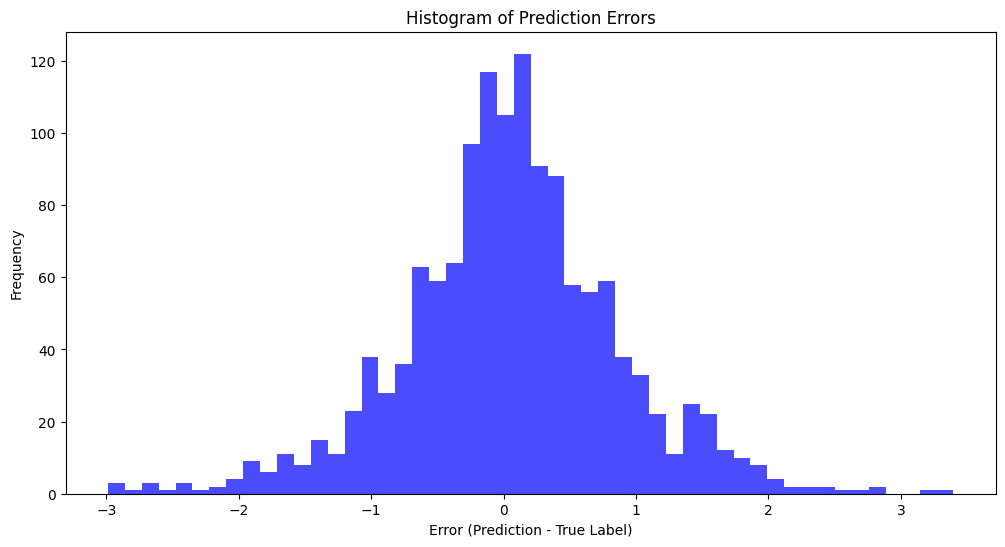

In [11]:
import matplotlib.pyplot as plt

# Histogram razlika između predikcija i stvarnih vrednosti
plt.figure(figsize=(12, 6))
plt.hist(predictions_array - np.array(test_dataset['labels']), bins=50, alpha=0.7, color='blue')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error (Prediction - True Label)')
plt.ylabel('Frequency')
plt.show()

Histogram prikazuje raspodelu grešaka modela pri predikciji sličnosti rečenica na STS-B datasetu. Greška se definiše kao razlika između predviđene vrednosti sličnosti i stvarne vrednosti sličnosti, tj. Error = Prediction - True Label.

Raspodela grešaka je simetrična i većina grešaka je koncentrisana oko nule. Ovo ukazuje da model ima uravnotežene predikcije i da ne favorizuje ni previsoke ni preniske vrednosti u odnosu na stvarne. Većina grešaka je relativno mala, što znači da su predikcije modela često blizu stvarnih vrednosti sličnosti.

Najveća frekvencija grešaka je u intervalu od -0.5 do 0.5, što pokazuje da je većina predikcija vrlo precizna. Manji broj grešaka u ekstremnim vrednostima (ispod -2 i iznad 2) ukazuje na to da model povremeno pravi veće greške, ali su takvi slučajevi retki.


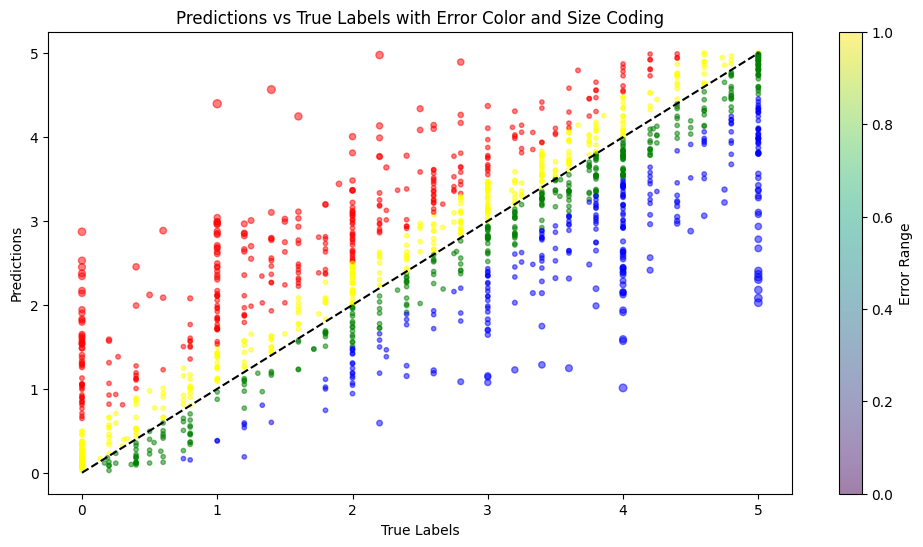

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Računanje greške
errors = predictions_array - np.array(test_dataset['labels'])

# Definisanje granica za boje i veličine tačaka
bins = [-np.inf, -0.5, 0, 0.5, np.inf]
colors = ['blue', 'green', 'yellow', 'red']
sizes = np.clip(np.abs(errors) * 10, 10, 100)

# Odredjivanje boje na osnovu grešaka
color_indices = np.digitize(errors, bins) - 1
colors_mapped = [colors[i] for i in color_indices]

# Scatter plot sa bojama i veličinama
plt.figure(figsize=(12, 6))
plt.scatter(test_dataset['labels'], predictions_array, s=sizes, c=colors_mapped, alpha=0.5)
plt.title('Predictions vs True Labels with Error Color and Size Coding')
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.plot([0, 5], [0, 5], color='black', linestyle='--')  # Dijagonala koja pokazuje savršenu tačnost
plt.colorbar(label='Error Range')
plt.show()

Ovaj scatter plot prikazuje predikcije modela u poređenju sa stvarnim vrednostima (True Labels). Boje i veličine tačaka na grafikonu ukazuju na veličinu grešaka između predikcija i stvarnih vrednosti. Što je tačka dalje od crne isprekidane linije (koja predstavlja savršenu tačnost), to je veća greška modela.

X osa predstavlja stvarne vrednosti (**True Labels**), dok Y osa prikazuje predikcije modela (**Predictions**).

Tačke su obojene u zavisnosti od veličine greške.


*   **Plava boja** ukazuje na velike negativne greške (predikcija znatno niža od stvarne vrednosti).
*   **Zelena boja** ukazuje na male negativne greške.
*   **Žuta boja** označava male pozitivne greške.
*   **Crvena boja** ukazuje na velike pozitivne greške (predikcija znatno viša od stvarne vrednosti).



Crna isprekidana linija na grafikonu predstavlja idealnu liniju savršenih predikcija, gde bi sve tačke ležale kada bi predikcije bile identične stvarnim vrednostima. Tačke koje se nalaze blizu crne dijagonale predstavljaju predikcije koje su blizu stvarnim vrednostima, što ukazuje na dobru tačnost modela. Tačke sa crvenom bojom, koje su dalje od dijagonale, pokazuju gde model ima velike pozitivne greške (npr. precenjuje vrednosti). Plave tačke koje se nalaze ispod dijagonale ukazuju na velike negativne greške, gde model podcenjuje vrednosti.

Raspon i raspodela boja i veličina omogućava brz vizuelni pregled gde model ima tendenciju grešaka i da li su te greške sistematske ili nasumične.

In [13]:
# Random Search za pretragu najbojih parametara
import random
from transformers import Trainer, TrainingArguments
import numpy as np

# Definisanje raspona vrednosti hiperparametara
param_ranges = {
    'per_device_train_batch_size': [8, 16, 32],
    'num_train_epochs': [3, 4, 5],
    'learning_rate': [5e-5, 3e-5, 2e-5]
}

# Broj iteracija Random Search-a
num_iterations = 10

best_params = None
best_eval_loss = float('inf')

for _ in range(num_iterations):
    params = {k: random.choice(v) for k, v in param_ranges.items()}

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=params['num_train_epochs'],
        per_device_train_batch_size=params['per_device_train_batch_size'],
        per_device_eval_batch_size=params['per_device_train_batch_size'],
        learning_rate=params['learning_rate'],
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset
    )

    trainer.train()
    eval_result = trainer.evaluate()

    eval_loss = eval_result['eval_loss']
    print(f"Params: {params}, Eval results: {eval_result}")

    # Praćenje najboljih rezultata
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_params = params

print(f"Best Params: {best_params}, Best Eval Loss: {best_eval_loss}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.132300,0.454899
2,0.134000,0.492936
3,0.136200,0.462081


Params: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 5e-05}, Eval results: {'eval_loss': 0.4620813727378845, 'eval_runtime': 6.9892, 'eval_samples_per_second': 214.615, 'eval_steps_per_second': 6.725, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.064300,0.444287
2,0.065400,0.461464
3,0.110700,0.462622


Params: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 5e-05}, Eval results: {'eval_loss': 0.4626220762729645, 'eval_runtime': 6.8662, 'eval_samples_per_second': 218.463, 'eval_steps_per_second': 6.845, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.038100,0.462993
2,0.055300,0.466769
3,0.087500,0.458826


Params: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 5e-05}, Eval results: {'eval_loss': 0.4588260054588318, 'eval_runtime': 6.9277, 'eval_samples_per_second': 216.522, 'eval_steps_per_second': 6.784, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.037200,0.500620
2,0.065500,0.547820
3,0.077400,0.455306


Params: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 5e-05}, Eval results: {'eval_loss': 0.45530641078948975, 'eval_runtime': 6.9628, 'eval_samples_per_second': 215.43, 'eval_steps_per_second': 6.75, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.032000,0.465093
2,0.051900,0.456145
3,0.063000,0.458027


Params: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 5e-05}, Eval results: {'eval_loss': 0.45802709460258484, 'eval_runtime': 6.9252, 'eval_samples_per_second': 216.599, 'eval_steps_per_second': 6.787, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.035600,0.476733
2,0.022500,0.466808
3,0.058700,0.449473


Params: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 5e-05}, Eval results: {'eval_loss': 0.44947272539138794, 'eval_runtime': 6.9684, 'eval_samples_per_second': 215.256, 'eval_steps_per_second': 6.745, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.033300,0.465217
2,0.036100,0.482493
3,0.053300,0.460020


Params: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 5e-05}, Eval results: {'eval_loss': 0.46001994609832764, 'eval_runtime': 7.2123, 'eval_samples_per_second': 207.977, 'eval_steps_per_second': 6.517, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.031500,0.477156
2,0.042100,0.503202
3,0.053100,0.463893


Params: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 5e-05}, Eval results: {'eval_loss': 0.46389302611351013, 'eval_runtime': 7.1928, 'eval_samples_per_second': 208.543, 'eval_steps_per_second': 6.534, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.040300,0.470757
2,0.042700,0.480037
3,0.043700,0.455723


Params: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 5e-05}, Eval results: {'eval_loss': 0.4557233154773712, 'eval_runtime': 7.2642, 'eval_samples_per_second': 206.491, 'eval_steps_per_second': 6.47, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.042800,0.469565
2,0.029900,0.506985
3,0.042600,0.466444


Params: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 5e-05}, Eval results: {'eval_loss': 0.4664444625377655, 'eval_runtime': 7.2204, 'eval_samples_per_second': 207.746, 'eval_steps_per_second': 6.509, 'epoch': 3.0}
Best Params: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 5e-05}, Best Eval Loss: 0.44947272539138794


In [14]:
# Definisanje najboljih hiperparametara (parametri koje nam je vratio Random Search)
best_params = {
    'per_device_train_batch_size': 32,
    'num_train_epochs': 3,
    'learning_rate': 5e-05
}

# Kreiranje TrainingArguments koristeći najbolje parametre
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=best_params['per_device_train_batch_size'],
    learning_rate=best_params['learning_rate'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Kreiranje Trainer-a sa optimizovanim parametrima
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset
)

# Ponovno treniranje modela sa najboljim parametrima
trainer.train()

# Evaluacija sa najboljim parametrima
eval_result = trainer.evaluate()
print(f"Final Eval results with best params: {eval_result}")

Step,Training Loss
10,0.036300
20,0.027300
30,0.019500
40,0.017300
50,0.017200
60,0.014100
70,0.014200
80,0.012000
90,0.011000
100,0.010300


Final Eval results with best params: {'eval_loss': 0.4624641239643097, 'eval_runtime': 7.2765, 'eval_samples_per_second': 206.143, 'eval_steps_per_second': 6.459, 'epoch': 3.0}


In [15]:
# Predikcija
predictions = trainer.predict(test_dataset)
predictions_array = np.array(predictions.predictions).flatten()
true_labels = np.array(test_dataset['labels'])

# Izračunavanje dodatnih metrika
mae = mean_absolute_error(true_labels, predictions_array)
rmse = np.sqrt(mean_squared_error(true_labels, predictions_array))
pearson_corr = np.corrcoef(true_labels, predictions_array)[0, 1]

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Pearson Correlation Coefficient: {pearson_corr}")

# Prikaz nekoliko predikcija i stvarnih vrednosti
print("Sample of predictions:", predictions_array[:10])
print("Sample of true labels:", test_dataset['labels'][:10])


Mean Absolute Error (MAE): 0.6027353890930749
Root Mean Squared Error (RMSE): 0.8121334563820318
Pearson Correlation Coefficient: 0.8465575737095719
Sample of predictions: [3.5104082 3.674241  5.071266  4.9224386 1.7124832 2.0615447 3.7044842
 1.7979985 2.214583  1.7025173]
Sample of true labels: [2.5, 3.5999999046325684, 5.0, 4.199999809265137, 1.5, 1.7999999523162842, 3.5, 2.200000047683716, 2.200000047683716, 1.7139999866485596]


In [16]:
# čuvanje prethodnih vrednosti
prev_mae = 0.6017700558370608
prev_rmse = 0.8162963018699607
prev_pearson_corr = 0.8464171151057571

# Prikaz trenutnih i prethodnih vrednosti
print(f"Previous MAE: {prev_mae}, New MAE: {mae}")
print(f"Previous RMSE: {prev_rmse}, New RMSE: {rmse}")
print(f"Previous Pearson Correlation: {prev_pearson_corr}, New Pearson Correlation: {pearson_corr}")

Previous MAE: 0.6017700558370608, New MAE: 0.6027353890930749
Previous RMSE: 0.8162963018699607, New RMSE: 0.8121334563820318
Previous Pearson Correlation: 0.8464171151057571, New Pearson Correlation: 0.8465575737095719


Rezultati sa novim hiperparametrima nisu pokazali poboljšanje u odnosu na rezultate koje smo postigli sa početnim modelom. Naime, došlo je do povećanja prosečne apsolutne greške (MAE) i korena srednje kvadratne greške (RMSE), dok su vrednosti Pearsonovog koeficijenta korelacije ostale relativno stabilne, ali su takođe pokazale blago smanjenje. Ovi rezultati sugerišu da su početni hiperparametri bili efikasniji za naš dataset. Stoga ćemo se vratiti na korišćenje početnih parametara za dalju obuku i evaluaciju modela kako bismo postigli optimalne rezultate.

In [17]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  # num_labels=1 jer se radi o regresiji

# Definiši TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Kreiraj Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,8.972900
20,10.498700
30,8.112400
40,7.882200
50,8.509100
60,5.223600
70,4.266700
80,2.381700
90,1.764100
100,1.546800


TrainOutput(global_step=2157, training_loss=0.6972223453406775, metrics={'train_runtime': 475.0193, 'train_samples_per_second': 36.308, 'train_steps_per_second': 4.541, 'total_flos': 1107870026375250.0, 'train_loss': 0.6972223453406775, 'epoch': 3.0})

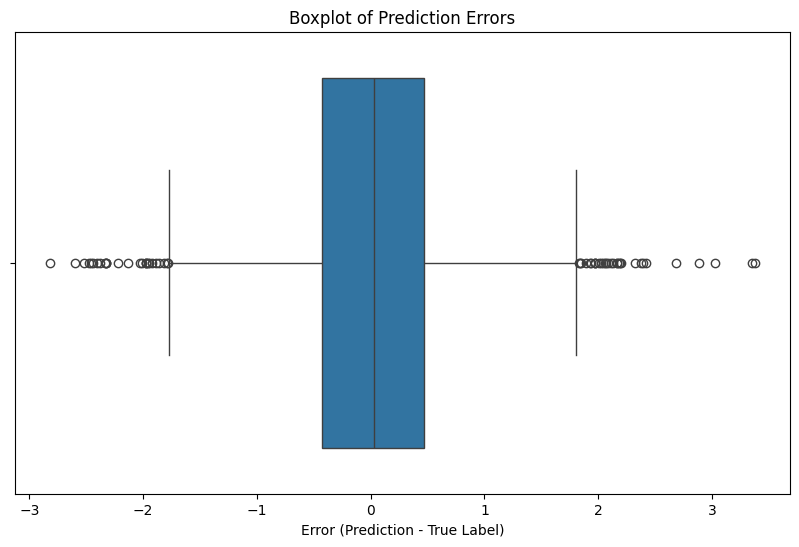

In [18]:
!pip install scikit-learn
!pip install seaborn

import seaborn as sns


errors = predictions_array - true_labels

plt.figure(figsize=(10, 6))
sns.boxplot(x=errors)
plt.title('Boxplot of Prediction Errors')
plt.xlabel('Error (Prediction - True Label)')
plt.show()

Ova slika prikazuje boxplot grešaka između predikcija i stvarnih vrednosti modela. Boxplot pokazuje da je medijana grešaka blizu nule, što ukazuje na to da model generalno dobro predviđa. Međutim, postoje neki outliersi (udaljene tačke) na obe strane, što sugeriše da u nekim slučajevima model pravi značajne greške. Ovi autlajeri mogu ukazivati na neobične podatke ili na potencijalno potrebne dodatne korake u pretprocesiranju ili poboljšanju modela.

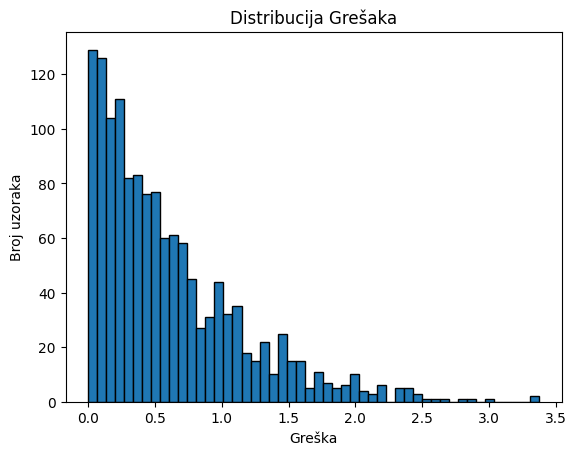

In [19]:
import matplotlib.pyplot as plt

errors = np.abs(predictions_array - np.array(test_dataset['labels']))

plt.hist(errors, bins=50, edgecolor='k')
plt.xlabel('Greška')
plt.ylabel('Broj uzoraka')
plt.title('Distribucija Grešaka')
plt.show()

Ovaj dijagram prikazuje distribuciju grešaka (odstupanja predikcija od stvarnih vrednosti) u modelu. Većina grešaka je koncentrisana oko nule, što ukazuje na to da model generalno daje tačne predikcije. Kako se greška povećava, broj uzoraka sa tom greškom značajno opada, što je očekivano ako model dobro funkcioniše. Međutim, postoji nekoliko uzoraka sa većim greškama, što bi moglo ukazivati na to da model ponekad ima problema sa određenim slučajevima.

In [20]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inicijalizacija BERT tokenizera i modela
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Funkcija za generisanje BERT embedding-a iz input podataka
def get_embeddings(input_ids, attention_mask):
    inputs = {
        'input_ids': torch.tensor(input_ids).to(device),
        'attention_mask': torch.tensor(attention_mask).to(device)
    }
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.pooler_output
    return embeddings.cpu().numpy()

# Pretvaranje test dataseta u numpy nizove
input_ids = test_dataset['input_ids']
attention_mask = test_dataset['attention_mask']

# Generisanje embedding-a za rečenice iz test dataseta
embeddings = get_embeddings(input_ids, attention_mask)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Initial Silhouette Score: 0.4121559262275696
Initial Davies-Bouldin Index: 0.9872961462037219


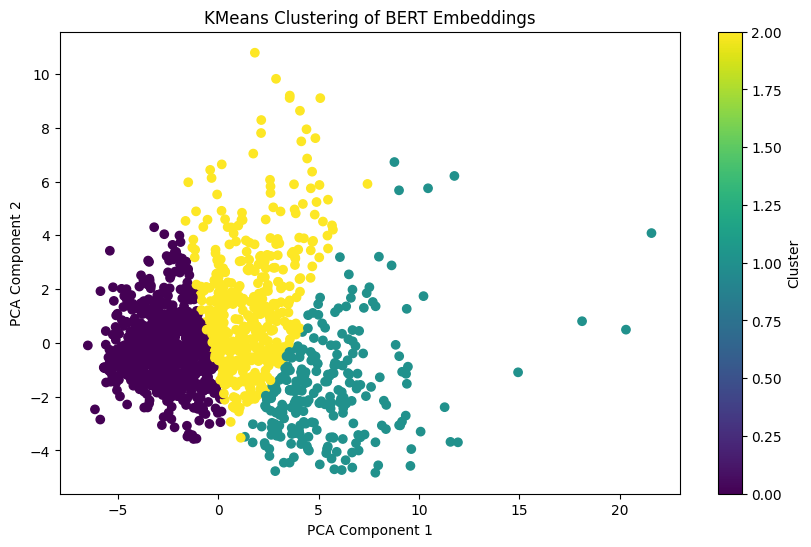

In [21]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Smanjivanje dimenzionalnosti na 2D za vizualizaciju
pca = PCA(n_components=2)
embeddings_reduced = pca.fit_transform(embeddings)

# Inicijalizacija KMeans sa početnim brojem klastera (npr. 3)
initial_n_clusters = 3

# Klasterovanje embeddings-a
kmeans_initial = KMeans(n_clusters=initial_n_clusters, random_state=42)
clusters_initial = kmeans_initial.fit_predict(embeddings_reduced)

# Računanje metrika
silhouette_initial = silhouette_score(embeddings_reduced, clusters_initial)
db_index_initial = davies_bouldin_score(embeddings_reduced, clusters_initial)

print(f"Initial Silhouette Score: {silhouette_initial}")
print(f"Initial Davies-Bouldin Index: {db_index_initial}")

# Prikaz klastera
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=clusters_initial, cmap='viridis', marker='o')
plt.title('KMeans Clustering of BERT Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [22]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inicijalizacija BERT tokenizera i modela
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Funkcija za generisanje BERT embedding-a korišćenjem mean pooling
def get_mean_pooling_embeddings(input_ids, attention_mask):
    inputs = {
        'input_ids': torch.tensor(input_ids).to(device),
        'attention_mask': torch.tensor(attention_mask).to(device)
    }
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state

        # Prosečan pooling svih skrivenih stanja za celu sekvencu
        # `mean_pooling` uzima prosečnu vrednost skrivenih stanja za sve tokene
        attention_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
        sum_hidden_states = torch.sum(last_hidden_state * attention_mask_expanded, 1)
        sum_attention_mask = torch.sum(attention_mask_expanded[:, :, 0], 1)
        mean_pooled = sum_hidden_states / sum_attention_mask.unsqueeze(-1)

    return mean_pooled.cpu().numpy()

# Pretvaranje test dataseta u numpy nizove i konverzija u tenzore
input_ids = torch.tensor(test_dataset['input_ids']).to(device)
attention_mask = torch.tensor(test_dataset['attention_mask']).to(device)

# Generisanje embedding-a za rečenice iz test dataseta
mean_pooled_embeddings = get_mean_pooling_embeddings(input_ids, attention_mask)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-22-2aa8aea5b4fd>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(input_ids).to(device),
<ipython-input-22-2aa8aea5b4fd>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(attention_mask).to(device)


Initial Silhouette Score: 0.6719194650650024
Initial Davies-Bouldin Index: 0.4743272345020144


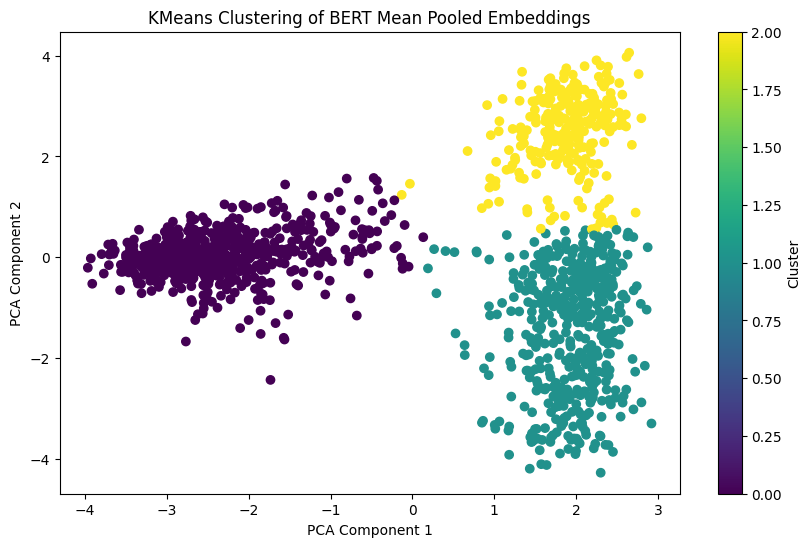

In [23]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Smanjivanje dimenzionalnosti na 2D za vizualizaciju
pca = PCA(n_components=2)
embeddings_reduced = pca.fit_transform(mean_pooled_embeddings)

# Inicijalizacija KMeans sa početnim brojem klastera (npr. 3)
initial_n_clusters = 3

# Klasterovanje embeddings-a
kmeans_initial = KMeans(n_clusters=initial_n_clusters, random_state=42)
clusters_initial = kmeans_initial.fit_predict(embeddings_reduced)

# Računanje metrika
silhouette_initial = silhouette_score(embeddings_reduced, clusters_initial)
db_index_initial = davies_bouldin_score(embeddings_reduced, clusters_initial)

print(f"Initial Silhouette Score: {silhouette_initial}")
print(f"Initial Davies-Bouldin Index: {db_index_initial}")

# Prikaz klastera
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=clusters_initial, cmap='viridis', marker='o')
plt.title('KMeans Clustering of BERT Mean Pooled Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [24]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd


# Podela dataseta na train set
train_dataset = dataset['train']

# Ekstrakcija rečenica iz train dataset-a
sentences = [item['sentence1'] for item in train_dataset]

# Inicijalizacija TF-IDF vektorizatora
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

# Izračunavanje kosinusne sličnosti
similarity_matrix = cosine_similarity(tfidf_matrix)

# Prikazivanje sličnosti između prvih nekoliko rečenica
similarity_df = pd.DataFrame(similarity_matrix)
print(similarity_df.head())

# Prikaz sličnosti između prvih 5 rečenica
for i in range(5):
    print(f"Sličnost između rečenice {i+1} i drugih rečenica:")
    print(similarity_df.iloc[i])
    print("\n")


       0         1         2         3         4         5         6     \
0  1.000000  0.055222  0.033963  0.000000  0.053953  0.000000  0.070149   
1  0.055222  1.000000  0.095017  0.131134  0.307728  0.000000  0.196250   
2  0.033963  0.095017  1.000000  0.000000  0.092834  0.000000  0.120701   
3  0.000000  0.131134  0.000000  1.000000  0.128122  0.332016  0.000000   
4  0.053953  0.307728  0.092834  0.128122  1.000000  0.000000  0.191741   

       7         8         9     ...  5739  5740  5741      5742      5743  \
0  0.060497  0.052196  0.041476  ...   0.0   0.0   0.0  0.000000  0.230749   
1  0.345051  0.297707  0.042787  ...   0.0   0.0   0.0  0.054738  0.000000   
2  0.104094  0.135684  0.062767  ...   0.0   0.0   0.0  0.033666  0.000000   
3  0.143661  0.123950  0.000000  ...   0.0   0.0   0.0  0.000000  0.000000   
4  0.426001  0.290868  0.072270  ...   0.0   0.0   0.0  0.053481  0.000000   

   5744  5745  5746  5747  5748  
0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.

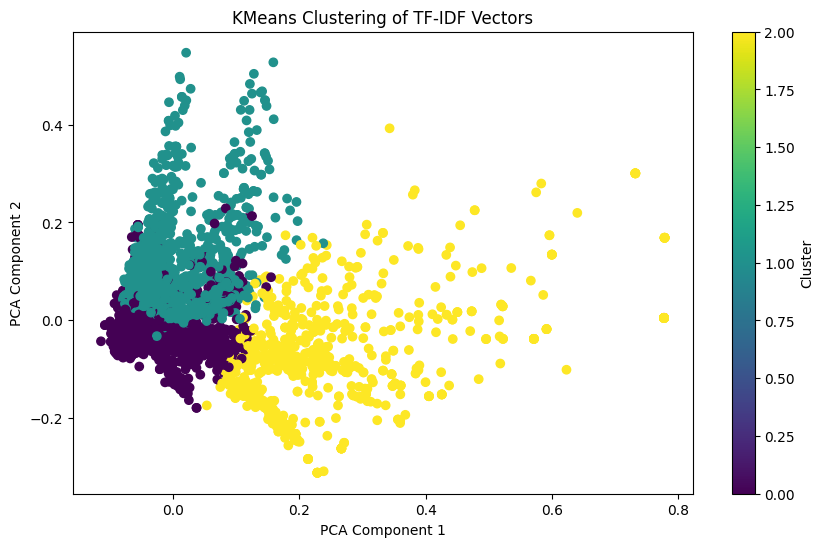

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from datasets import load_dataset


# Ekstrakcija rečenica iz train dataset-a
sentences = [item['sentence1'] for item in train_dataset]

# Generisanje TF-IDF matrice
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

# Klasterovanje KMeans
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Smanjivanje dimenzionalnosti na 2D
pca = PCA(n_components=2)
tfidf_reduced = pca.fit_transform(tfidf_matrix.toarray())

# Prikaz klastera
plt.figure(figsize=(10, 6))
plt.scatter(tfidf_reduced[:, 0], tfidf_reduced[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('KMeans Clustering of TF-IDF Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()